In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
temp = pd.read_csv("/content/drive/MyDrive/Model/LSTM_Finals/Dataset/Final_Dataset/Carrot_Local.csv")

In [ ]:
temp.drop('Commodity', axis=1, inplace=True)

In [ ]:
temp.head()

,Date,Average
0,6/16/2013,32.5
1,6/17/2013,37.5
2,6/18/2013,37.5
3,6/19/2013,40.0
4,6/20/2013,41.0


In [ ]:
#Normalizing the average column
scaler = MinMaxScaler()
temp['Average'] = scaler.fit_transform(temp['Average'].values.reshape(-1, 1))

In [ ]:
#converting date to datetime format and using date as index
temp['Date'] = pd.to_datetime(temp['Date'])
temp['Date'] = temp['Date'].dt.strftime('%m-%d-%Y')
temp.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

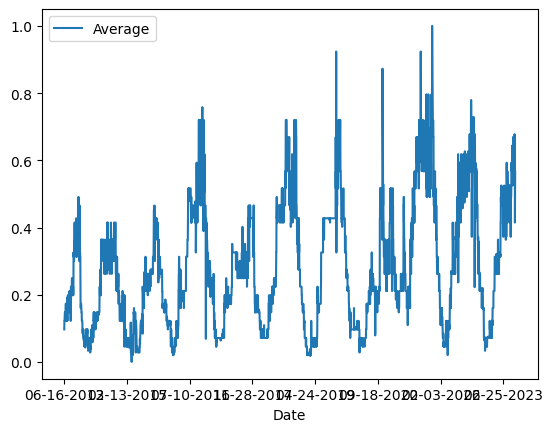

In [ ]:
temp.plot()

In [ ]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)

In [ ]:
print(X1.shape, y1.shape)

(3591, 5, 1, 1) (3591, 1)


In [ ]:
X1= np.squeeze(X1)
y1 = np.squeeze(y1)
# Print the new shapes
print(X1.shape, y1.shape)

(3591, 5) (3591,)


In [ ]:
X_train1, y_train1 = X1[:2500], y1[:2500]
X_val1, y_val1 = X1[2500:3000], y1[2500:3000]
X_test1, y_test1 = X1[3000:], y1[3000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((2500, 5), (2500,), (500, 5), (500,), (591, 5), (591,))

In [ ]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
)

In [ ]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1])

Epoch 1/100
79/79 [==============================] - 5s 39ms/step - loss: 0.0520 - root_mean_squared_error: 0.2280 - mean_absolute_error: 0.1737 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308 - val_mean_absolute_error: 0.0984
Epoch 2/100
79/79 [==============================] - 3s 39ms/step - loss: 0.0048 - root_mean_squared_error: 0.0692 - mean_absolute_error: 0.0524 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886 - val_mean_absolute_error: 0.0633
Epoch 3/100
79/79 [==============================] - 3s 36ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0325 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793 - val_mean_absolute_error: 0.0546
Epoch 4/100
79/79 [==============================] - 2s 31ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - mean_absolute_error: 0.0304 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779 - val_mean_absolute_error: 0.0537
Epoch 5/100
79/79 [==============================] - 3s 

In [ ]:
model1 = load_model("/content/drive/MyDrive/Model/LSTM_Finals/LSTM_carrot_model.h5")

In [ ]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

79/79 [==============================] - 1s 4ms/step


,Train Predictions,Actuals
0,0.139210,0.147583
1,0.147156,0.147583
2,0.150339,0.122137
3,0.138007,0.139949
4,0.143159,0.139949
...,...,...
2495,0.197647,0.173028
2496,0.185295,0.173028
2497,0.183045,0.173028
2498,0.181181,0.173028


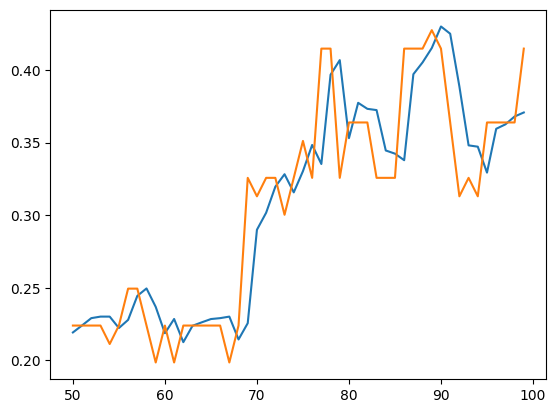

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results.tail()

16/16 [==============================] - 0s 3ms/step


,Val Predictions,Actuals
495,0.165889,0.109415
496,0.136909,0.109415
497,0.126533,0.160305
498,0.148781,0.160305
499,0.156248,0.160305


In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

19/19 [==============================] - 3s 15ms/step


,Test Predictions,Actuals
0,0.160247,0.160305
1,0.163792,0.160305
2,0.165889,0.160305
3,0.165889,0.160305
4,0.165889,0.160305
...,...,...
586,0.671283,0.669211
587,0.648848,0.626819
588,0.630562,0.414758
589,0.468562,0.525038


In [ ]:
#TEST MSE,MAE and RMSC
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test1, test_predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test1, test_predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

In [ ]:
#Print MSE,MAE and RMSC
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.0023338058739815364
Mean Absolute Error (MAE): 0.030024561248421202
Root Mean Squared Error (RMSE): 0.04830948016674922


In [ ]:
# Calculate R^2 score
r2score = r2_score(y_test1, test_predictions)

print("R^2 Score:", r2score)
accuracy_percentage = r2score * 100
print("Accuracy (R^2 Score) in Percentage:", accuracy_percentage)

R^2 Score: 0.9416268346767539
Accuracy (R^2 Score) in Percentage: 94.1626834676754


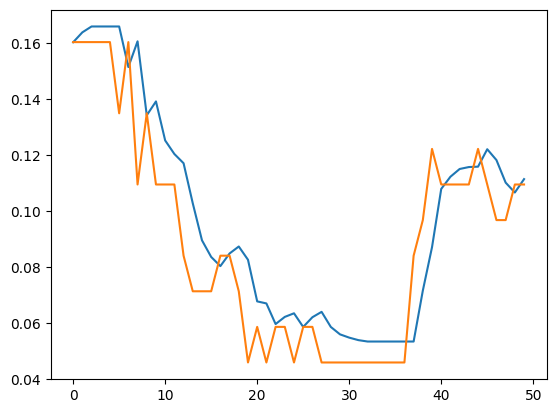

In [ ]:
plt.plot(test_results['Test Predictions'][:50])
plt.plot(test_results['Actuals'][:50])

In [ ]:
future_steps = 10
# Start with the last sequence from the test set
current_sequence = [0.56839377,0.57203543 ,0.57567686 ,0.57942027 ,0.58303988]

# Initialize an array to store the forecasted values
forecasted_values = []

# Iterate to predict future steps
for i in range(future_steps):
    # Predict the next value
    next_value_normalized = model1.predict(np.expand_dims(current_sequence, axis=0))[0][0]

    # Denormalize the predicted value
    next_value = scaler.inverse_transform([[next_value_normalized]])[0][0]

    # Append the denormalized predicted value to the forecasted values
    forecasted_values.append(next_value)

    # Update the current sequence by removing the first element and adding the predicted value at the end
    current_sequence = np.append(current_sequence[1:], next_value_normalized)

# Print the forecasted values
print("Forecasted Values for the next", future_steps, "steps:", forecasted_values)

1/1 [==============================] - 0s 32ms/step
Forecasted Values for the next 10 steps: [128.7390492260456, 129.37732341885567, 129.98754662275314, 130.5699062347412, 131.12380492687225, 131.6497111916542, 132.14855030179024, 132.62111869454384, 133.0682596564293, 133.49078133702278]


In [ ]:
print(current_sequence)

[0.56839377 0.57203543 0.57567686 0.57942027 0.58303988]


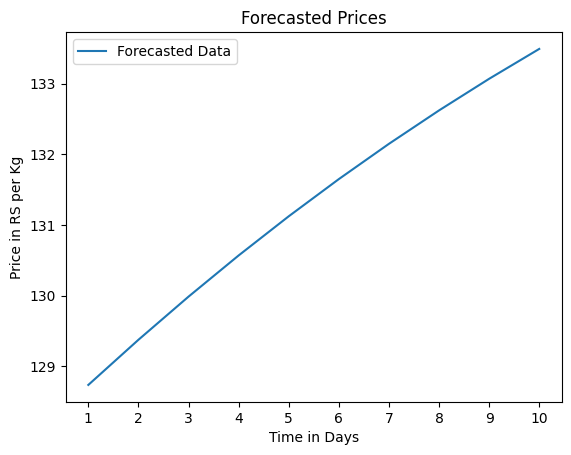

In [ ]:
# Plot forecasted values
plt.plot(range(1, future_steps + 1), forecasted_values, label='Forecasted Data')

# Set labels and title
plt.xlabel('Time in Days')
plt.ylabel('Price in RS per Kg')
plt.title('Forecasted Prices')
plt.legend()

# Set x-axis ticks to show 1, 2, 3, ..., future_steps
plt.xticks(range(1, future_steps + 1))

# Show plot
plt.show()